# In class exercises for ML tutorials

## Read in data from eeg study
* This time I've kept in data across a 1s window from many electrodes (20) sampled at 250Hz, so now we have a [960, 20, 250] matrix that contains data from all 960 trials, 20 electrodes, and over a 1s window following stimulus onset
* Also read in a "cond_labels" vector that has 960 0's and 1's to mark trials from the two experimental conditions 

## import stuff...

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh

# Support vector classifier
from sklearn.svm import SVC 

# also define the default font we'll use for figures. 
fig_font = {'fontname':'Arial', 'size':'20'}

In [2]:
# load the data...
eeg = np.load('class_demo_eeg.npz')

# get the different arrays like this...
eeg['data']
eeg['sr']
eeg['tx']
eeg['cond_labels']

# shape of data
print('Shape of the big eeg data set: ', eeg['data'].shape)

# and if you want to save some typing, especially because we only have a few variables, you reassign the different arrays like this
data = eeg['data']
sr = eeg['sr']
tx = eeg['tx']
cond_labels = eeg['cond_labels']


Shape of the big eeg data set:  (960, 20, 250)


## Compute the mean across the first dimension (trials) and then plot the mean response across time in each of the 20 electrodes on one axis

* Might need to transpose the data into a Time x Electrode format

(250, 20)
(250,)


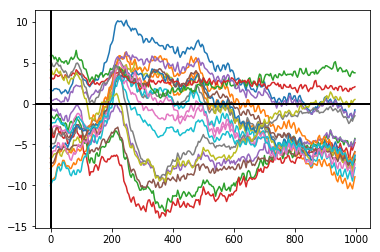

In [3]:
trial_mean = np.mean(data, axis=0)
print(np.shape(trial_mean.T))
print(np.shape(tx))
plt.plot(tx, trial_mean.T)
plt.axvline(0, color = 'k', linewidth = 2)
plt.axhline(0, color = 'k', linewidth = 2)
plt.show()

## That gives you an idea about what the pattern of data looks like across electrodes. 
* Next, take the mean across time, so you have a 960 x 20 matrix 
* Use the cond_labels vector to sort the data based on condition (so you have two 480 x 20 matrices)
* Do classification to see if you can decode the experimental condition
* Remember - break up your data into independent training and testing sets
* Set C to a small number if this is taking a long time...

In [9]:
time_mean = np.mean(data, axis=2)
print(np.shape(time_mean))

cond1_data = time_mean[cond_labels==0,:]
cond2_data = time_mean[cond_labels==1,:]

# first lets assign parts of our data to train and test sets
# this is the same approach that we used for the distance based classifiers in the 
# first part of the tutorial.
percent_train_set = .9
trn_length = int(np.round(percent_train_set*cond1_data.shape[0]))
tst_length = int(np.round((1 - percent_train_set)*cond1_data.shape[0]))

# now assign the first 90% of the trials to the training set...
# we'll stack up the first 90% from the first condition on top 
# of the 90% of data from the second condition
trn_data = np.vstack((cond1_data[:trn_length,:], cond2_data[:trn_length,:]))

# and the last 10% of the trials get stacked to make the test set...
tst_data = np.vstack((cond1_data[trn_length:,:], cond2_data[trn_length:,:]))

# last generate a vector that labels the data from each trial
# as belonging to condition 1 or condition 2
trn_labels = np.hstack((np.zeros(trn_length), np.ones(trn_length))).T
tst_labels = np.hstack((np.zeros(tst_length), np.ones(tst_length))).T

# The SVC was imported earlier via the sklearn module
# so we can train the classifer using our data.


# allocate an array to store our classification labels  
class_labels = np.zeros(tst_data.shape[0]) 
for i in np.arange(tst_data.shape[0]):
    # compute Euc distance from each point to the mean of first condition
    # sqrt of sum if squared distances...
    distance0 = np.sqrt( np.sum( np.power( (tst_data[i,:]-cond1_data) , 2) ) )
    distance1 = np.sqrt( np.sum( np.power( (tst_data[i,:]-cond2_data) , 2) ) )
    # then figure out which distance is smaller (or which cloud our test point is closer to)
    class_labels[i] = np.argmin([distance0, distance1])
    
# Then just compute our classification accuracy by comparing the predicted labels to the ground truth
class_acc = np.sum(class_labels==tst_labels) /  tst_data.shape[0]
print('Classification accuracy is: ', class_acc)




# first specify the model...linear SVM with a large criterion value
# if C is big, that will enforce a hard margin...if C is small, it 
# will allow some leakage of points over the margin.
model = SVC(kernel='linear', C=1)

# then fit the model to our training data by passing in the data matrix + a list of labels that denotes the 
# experimental condition for each trial
model.fit(trn_data, trn_labels)

# then predict
class_labels = model.predict(tst_data)

# Then just compute our classification accuracy by comparing the predicted labels to the ground truth
class_acc = np.sum(class_labels==tst_labels) /  tst_data.shape[0]
print('Classification accuracy with a SVM is: ', class_acc)

(960, 20)
Classification accuracy is:  0.71875
Classification accuracy with a SVM is:  0.5520833333333334


## Now try doing this across timepoints!
* First do a time window based on where you think there is nice separation in the responses across electrodes (look at the data that you plotted above)...maybe try 300-400msec post stim
* Then you can try timepoint x timepoint or a moving window

In [11]:
time_window = (tx >= 300) & (tx < 400)

short_data = data[:, :, time_window]
time_mean = np.mean(short_data, axis=2)

cond1_data = time_mean[cond_labels==0,:]
cond2_data = time_mean[cond_labels==1,:]

percent_train_set = .9
trn_length = int(np.round(percent_train_set*cond1_data.shape[0]))
tst_length = int(np.round((1 - percent_train_set)*cond1_data.shape[0]))

trn_data = np.vstack((cond1_data[:trn_length,:], cond2_data[:trn_length,:]))

tst_data = np.vstack((cond1_data[trn_length:,:], cond2_data[trn_length:,:]))

trn_labels = np.hstack((np.zeros(trn_length), np.ones(trn_length))).T
tst_labels = np.hstack((np.zeros(tst_length), np.ones(tst_length))).T

model = SVC(kernel='linear', C=1)

model.fit(trn_data, trn_labels)

# then predict
class_labels = model.predict(tst_data)

# Then just compute our classification accuracy by comparing the predicted labels to the ground truth
class_acc = np.sum(class_labels==tst_labels) /  tst_data.shape[0]
print('Classification accuracy with a SVM is: ', class_acc)

Classification accuracy with a SVM is:  0.6770833333333334


## Bonus - try using randomization testing to eval significance